In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

import pandas as pd

# Pytorch
import torch
torch.manual_seed(29)
from torch import nn
from torch.nn import functional as TFunc
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torchvision.transforms as transforms

from twrap.utils import model_summary, tensor_to_torch_var
from utils.models import *
from utils.stn_models import *
from torch.utils.data import DataLoader
from utils.datasets import dataset_nonvisob
from twrap.transform import ToZNorm

from twrap.utils import genROC

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

from glob import glob
from sklearn.metrics import roc_curve
from skimage.transform import resize

from utils.model_utils import genRegionMask



In [2]:
transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(160),
#     transforms.CenterCrop(160),
    transforms.CenterCrop(160),
#     ToZNorm()
    transforms.ToTensor()
    ])


In [3]:
def dprime(targets, scores):
    
    Zt = scores[targets==1]
    Ztm = np.mean(Zt)
    Ztv = np.var(Zt)
    
    Zn = scores[targets==0]
    Znm = np.mean(Zn)
    Znv = np.var(Zn)
    
    d_1 = np.abs(Znm - Ztm)
    d_2 = (0.5 * (Ztv + Znv))**0.5
    
    return d_1/d_2

In [4]:
model = STNMODEL_4(400, classify = False, attention = True, illum_inv=True)
check_point_file = '/media/cibitaw1/DATA/SUMMER2019/OCULARNETV2.1/EXTEND01/weights/STNMODEL_4_SPOOF.ONLY_WIN/model_best.pth.tar'
checkpoint = torch.load(check_point_file, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])

# check_point_file = '/home/narsi/Desktop/MODEL4_MITG_EXP01/model_best.pth.tar'
# model.regions = genRegionMask(w = 20, s1 = 13, s2 = 7, s3 = 7, s4 = 2)
# model.regions.data.requires_grad = False
model.cuda()
model.eval()
print('.')

.


In [5]:
src_fldr = '/media/cibitaw1/datasets/EXTENDED/FERET'#, '*_rb_*.png', '*_rc_*.png'
e_dataset = dataset_nonvisob(src_fldr, img_type = '*_fa_*.png', transform = transform)
v_dataset = dataset_nonvisob(src_fldr, img_type = ['*_fb_*.png'], transform = transform)

dataset_loader = DataLoader(e_dataset, num_workers=8, pin_memory=True, batch_size=128)
e_feat = []
e_labels = []

with torch.no_grad():
    for (batch_data, batch_target) in tqdm(dataset_loader):

        input_var = tensor_to_torch_var(batch_data, True)
        e_feat.append(model(input_var)[0].data.cpu())#
        e_labels += batch_target
        del input_var

    e_feat = torch.cat(e_feat, dim = 0)
    e_labels = np.asarray(e_labels, dtype = np.object)

dataset_loader = DataLoader(v_dataset, num_workers=8, pin_memory=True, batch_size=128)
v_feat = []
v_labels = []

with torch.no_grad():
    for (batch_data, batch_target) in tqdm(dataset_loader):

        input_var = tensor_to_torch_var(batch_data, True)
        v_feat.append(model(input_var)[0].data.cpu())#[0]
        v_labels += batch_target
        del input_var

    v_feat = torch.cat(v_feat, dim = 0)
    v_labels = np.asarray(v_labels, dtype = np.object)


    e_feat = e_feat.cuda()

100%|██████████| 21/21 [00:07<00:00,  1.61it/s]


In [ ]:
cmc_50 = np.zeros(shape=(150, ), dtype=np.float64)
mt_cmc_50 = np.zeros(shape=(50, ), dtype=np.float64)
count = 0
mt_count = 0
scores = []
targets = []

mt_scores = []
mt_targets = []

ids = np.arange(v_feat.shape[0])
with torch.no_grad():
    for i in tqdm(range(v_feat.shape[0])):
        # i = 1
        v_f = v_feat[i:i+1, ...].cuda()
        v_l = v_labels[i]

#         s = F.cosine_similarity(e_feat, v_f).data.cpu().numpy()
        s = (e_feat*v_f).sum(1).data.cpu().numpy()
        t = 1 * (e_labels == v_l)

        scores.append(s)
        targets.append(t)
        if np.sum(t) != 0:
            locs = np.argsort(-1 * s)
            t_50 = t[locs[:150]]
            t_50 = np.cumsum(t_50)
            t_50[t_50 >= 1] = 1
            cmc_50 += t_50
            count+=1
        
        s_mt_ = []
        t_mt_ = []

        for esub in list(np.unique(e_labels)):

            ms = np.max(s[e_labels == esub])
            mt = 1 * (esub == v_l)

            mt_scores.append(ms)
            mt_targets.append(mt)

            s_mt_.append(ms)
            t_mt_.append(mt)

        s_mt_ = np.asarray(s_mt_)
        t_mt_ = np.asarray(t_mt_)
        if np.sum(t) != 0:
            locs = np.argsort(-1 * s_mt_)
            t_50 = t_mt_[locs[:50]]
            t_50 = np.cumsum(t_50)
            t_50[t_50 >= 1] = 1
            mt_cmc_50 += t_50
            mt_count+=1
        

scores = np.concatenate(scores)
targets = np.concatenate(targets)

mt_scores = np.asarray(mt_scores, dtype = np.float32)
mt_targets = np.asarray(mt_targets, dtype = np.float32)

 70%|██████▉   | 1856/2664 [02:33<01:06, 12.17it/s]

In [ ]:
print('Single Frame:')
print('-------------')
print('RANK - 1       ::' + '{0:0.2f}'.format(cmc_50[0] * 100/count) + '%')
print('RANK - 10      ::' + '{0:0.2f}'.format(cmc_50[9] * 100/count) + '%')
print('D-prime        ::' + '{0:0.2f}'.format(dprime(targets, scores)))
far_sf, tar_sf, _ = roc_curve(targets, scores)
fpr_sf = 1 - tar_sf
EER = fpr_sf[np.nanargmin(np.absolute((far_sf - fpr_sf)))]
print('GMR @ 0.1% FMR ::' + '{0:0.2f}'.format(np.min(tar_sf[far_sf>= 0.001] * 100)) + '%')
print('GMR @ 1% FMR   ::' + '{0:0.2f}'.format(np.min(tar_sf[far_sf>= 0.01] * 100)) + '%')
print('EER (%)        ::' + '{0:0.2f}'.format(EER*100.0))

print('Multi Frame:')
print('-------------')
print('RANK - 1       ::' + '{0:0.2f}'.format(mt_cmc_50[0] * 100/mt_count) + '%')
print('RANK - 10      ::' + '{0:0.2f}'.format(mt_cmc_50[9] * 100/mt_count) + '%')
print('D-prime        ::' + '{0:0.2f}'.format(dprime(mt_targets, mt_scores)))
far_mt, tar_mt, _ = roc_curve(mt_targets, mt_scores)
fpr_mt = 1 - tar_mt
EER = fpr_mt[np.nanargmin(np.absolute((far_mt - fpr_mt)))]
print('GMR @ 0.1% FMR ::' + '{0:0.2f}'.format(np.min(tar_mt[far_mt>= 0.001] * 100)) + '%')
print('GMR @ 1% FMR   ::' + '{0:0.2f}'.format(np.min(tar_mt[far_mt>= 0.01] * 100)) + '%')
print('EER (%)        ::' + '{0:0.2f}'.format(EER*100.0))

UBIRIS-V2(Long Dist)
=================
Single Frame:
-------------
RANK - 1       ::53.28%
RANK - 10      ::84.29%
D-prime        ::1.93
GMR @ 0.1% FMR ::21.71%
GMR @ 1% FMR   ::43.72%
EER (%)        ::16.85
Multi Frame:
-------------
RANK - 1       ::53.28%
RANK - 10      ::86.51%
D-prime        ::2.89
GMR @ 0.1% FMR ::43.36%
GMR @ 1% FMR   ::72.30%
EER (%)        ::7.65

UBIRIS-V2(ALL data)
=================
Single Frame:
-------------
RANK - 1       ::51.26%
RANK - 10      ::81.23%
D-prime        ::1.59
GMR @ 0.1% FMR ::15.48%
GMR @ 1% FMR   ::33.72%
EER (%)        ::21.34
Multi Frame:
-------------
RANK - 1       ::51.26%
RANK - 10      ::83.17%
D-prime        ::2.70
GMR @ 0.1% FMR ::42.34%
GMR @ 1% FMR   ::69.82%
EER (%)        ::9.10

UBIPR (D1 vs D2-5)
================
Single Frame:
-------------
RANK - 1       ::79.84%
RANK - 10      ::94.99%
D-prime        ::1.86
GMR @ 0.1% FMR ::27.61%
GMR @ 1% FMR   ::46.21%
EER (%)        ::17.57
Multi Frame:
-------------
RANK - 1       ::79.84%
RANK - 10      ::95.54%
D-prime        ::3.17
GMR @ 0.1% FMR ::62.99%
GMR @ 1% FMR   ::82.51%
EER (%)        ::6.06


FERET (fa vs fb)
======
Single Frame:
-------------
RANK - 1       ::87.28%
RANK - 10      ::93.40%
D-prime        ::2.56
GMR @ 0.1% FMR ::64.22%
GMR @ 1% FMR   ::76.19%
EER (%)        ::10.88
Multi Frame:
-------------
RANK - 1       ::87.28%
RANK - 10      ::93.51%
D-prime        ::3.90
GMR @ 0.1% FMR ::85.89%
GMR @ 1% FMR   ::92.98%
EER (%)        ::3.77


FERET (fa vs all)
======
Single Frame:
-------------
RANK - 1       ::81.23%
RANK - 10      ::91.26%
D-prime        ::2.47
GMR @ 0.1% FMR ::57.75%
GMR @ 1% FMR   ::73.14%
EER (%)        ::10.94
Multi Frame:
-------------
RANK - 1       ::81.23%
RANK - 10      ::91.37%
D-prime        ::3.36
GMR @ 0.1% FMR ::77.28%
GMR @ 1% FMR   ::88.69%
EER (%)        ::5.30

CROSSEYED(IRIS)
===============
Single Frame:
-------------
RANK - 1       ::94.11%
RANK - 10      ::98.28%
D-prime        ::3.37
GMR @ 0.1% FMR ::55.55%
GMR @ 1% FMR   ::83.84%
EER (%)        ::5.42
Multi Frame:
-------------
RANK - 1       ::94.11%
RANK - 10      ::99.43%
D-prime        ::3.99
GMR @ 0.1% FMR ::68.75%
GMR @ 1% FMR   ::92.14%
EER (%)        ::2.71

CROSSEYED(PERI)
================
Single Frame:
-------------
RANK - 1       ::99.17%
RANK - 10      ::99.90%
D-prime        ::3.86
GMR @ 0.1% FMR ::83.11%
GMR @ 1% FMR   ::92.40%
EER (%)        ::4.09
Multi Frame:
-------------
RANK - 1       ::99.17%
RANK - 10      ::100.00%
D-prime        ::4.94
GMR @ 0.1% FMR ::93.75%
GMR @ 1% FMR   ::99.17%
EER (%)        ::0.94

-->VISOB200+SPOOFDATA
--------------------------------------
UBIPR (D1 vs D2-5)
================
Single Frame:
-------------
RANK - 1       ::91.57%
RANK - 10      ::99.34%
D-prime        ::2.71
GMR @ 0.1% FMR ::46.16%
GMR @ 1% FMR   ::70.87%
EER (%)        ::8.57
Multi Frame:
-------------
RANK - 1       ::91.57%
RANK - 10      ::99.49%
D-prime        ::4.26
GMR @ 0.1% FMR ::83.78%
GMR @ 1% FMR   ::95.59%
EER (%)        ::2.39

UBIRIS-V2(ALL data)
=================
Single Frame:
-------------
RANK - 1       ::61.62%
RANK - 10      ::91.05%
D-prime        ::2.05
GMR @ 0.1% FMR ::24.09%
GMR @ 1% FMR   ::48.35%
EER (%)        ::15.33
Multi Frame:
-------------
RANK - 1       ::61.62%
RANK - 10      ::92.72%
D-prime        ::3.21
GMR @ 0.1% FMR ::53.77%
GMR @ 1% FMR   ::80.81%
EER (%)        ::5.93
UBIRIS-V2(Long Dist)
=================
Single Frame:
-------------
RANK - 1       ::64.34%
RANK - 10      ::93.02%
D-prime        ::2.52
GMR @ 0.1% FMR ::33.22%
GMR @ 1% FMR   ::61.26%
EER (%)        ::10.66
Multi Frame:
-------------
RANK - 1       ::64.34%
RANK - 10      ::94.47%
D-prime        ::3.42
GMR @ 0.1% FMR ::56.74%
GMR @ 1% FMR   ::84.81%
EER (%)        ::4.96
CROSSEYED(IRIS)
===============
Single Frame:
-------------
RANK - 1       ::98.85%
RANK - 10      ::99.90%
D-prime        ::3.88
GMR @ 0.1% FMR ::71.05%
GMR @ 1% FMR   ::90.07%
EER (%)        ::4.08
Multi Frame:
-------------
RANK - 1       ::98.85%
RANK - 10      ::99.95%
D-prime        ::4.66
GMR @ 0.1% FMR ::85.16%
GMR @ 1% FMR   ::97.29%
EER (%)        ::1.51
CROSSEYED(PERI)
================
Single Frame:
-------------
RANK - 1       ::100.00%
RANK - 10      ::100.00%
D-prime        ::4.59
GMR @ 0.1% FMR ::93.03%
GMR @ 1% FMR   ::96.50%
EER (%)        ::2.32
Multi Frame:
-------------
RANK - 1       ::100.00%
RANK - 10      ::100.00%
D-prime        ::5.64
GMR @ 0.1% FMR ::99.27%
GMR @ 1% FMR   ::100.00%
EER (%)        ::0.21

FERET (fa vs all)
======
Single Frame:
-------------
RANK - 1       ::90.84%
RANK - 10      ::96.98%
D-prime        ::3.19
GMR @ 0.1% FMR ::70.75%
GMR @ 1% FMR   ::85.10%
EER (%)        ::5.79
Multi Frame:
-------------
RANK - 1       ::90.84%
RANK - 10      ::97.01%
D-prime        ::4.35
GMR @ 0.1% FMR ::89.33%
GMR @ 1% FMR   ::96.01%
EER (%)        ::2.53

FERET (fa vs fb)
======
Single Frame:
-------------
RANK - 1       ::93.81%
RANK - 10      ::97.58%
D-prime        ::3.25
GMR @ 0.1% FMR ::73.40%
GMR @ 1% FMR   ::85.43%
EER (%)        ::5.72
Multi Frame:
-------------
RANK - 1       ::93.81%
RANK - 10      ::97.58%
D-prime        ::4.86
GMR @ 0.1% FMR ::93.06%
GMR @ 1% FMR   ::97.17%
EER (%)        ::2.00

In [8]:
dprime(targets, scores)

1.9313672969967872

In [9]:
dprime(mt_targets, mt_scores)

2.887395717379254

In [10]:
x = plt.hist(scores[targets == 0], bins = 100, density=True)
y = plt.hist(scores[targets == 1], bins = 100, density=True)
plt.close()

x1 = plt.hist(mt_scores[mt_targets == 0], bins = 100, density=True)
y1 = plt.hist(mt_scores[mt_targets == 1], bins = 100, density=True)
plt.close()

plt.plot(-1 * x[0], x[1][1:])
plt.plot(y[0], y[1][1:])

plt.plot(-1 * x1[0], x1[1][1:])
plt.plot(y1[0], y1[1][1:])

Text(0.5, 1.0, 'GMR @ 0.001 FMR 21.71%')

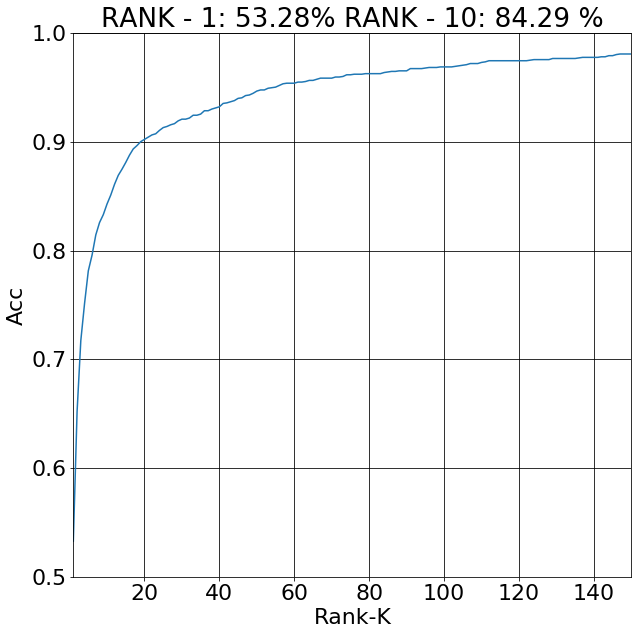

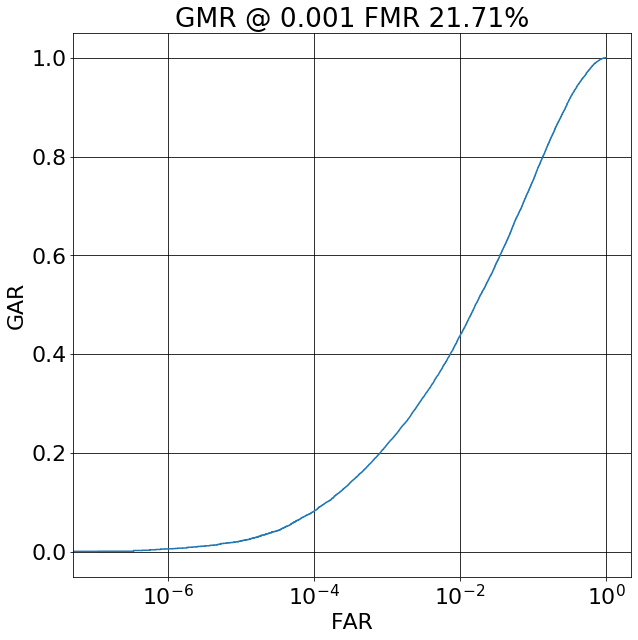

In [11]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 151), cmc_50/count)
plt.xlim([1, 150])
plt.ylim([0.50, 1.00])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(cmc_50[0] * 100/count) + '% RANK - 10: ' + '{0:0.2f}'.format(cmc_50[9] * 100/count) + ' %')
        
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(targets, scores)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')

Text(0.5, 1.0, 'GMR @ 0.001 FMR 43.36%')

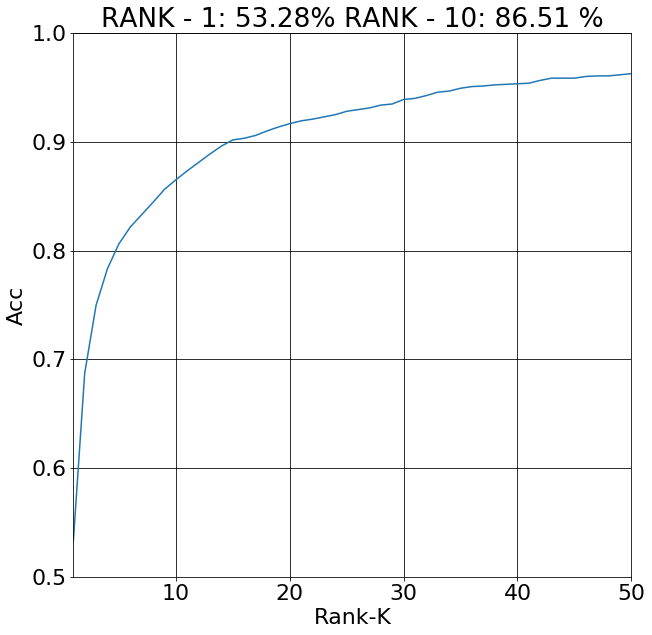

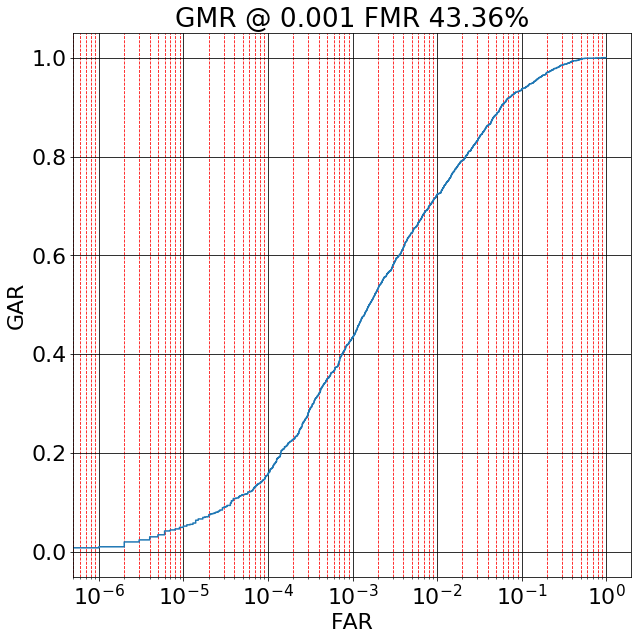

In [12]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 51), mt_cmc_50/mt_count)
plt.xlim([1, 50])
plt.ylim([0.50, 1.00])
plt.xlabel('Rank-K')
plt.ylabel('Acc')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.title('RANK - 1: ' + '{0:0.2f}'.format(mt_cmc_50[0] * 100/mt_count) + '% RANK - 10: ' + '{0:0.2f}'.format(mt_cmc_50[9] * 100/mt_count) + ' %')
        
plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(mt_targets, mt_scores)
plt.semilogx(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')

In [13]:
fpr = 1 - tar
EER = fpr[np.nanargmin(np.absolute((far - fpr)))]

In [14]:
EER

0.07648578811369511

In [15]:
np.min(np.absolute((far - fpr)))

0.0004814425770307898

Text(0.5, 1.0, 'GMR @ 0.001 FMR 43.36%')

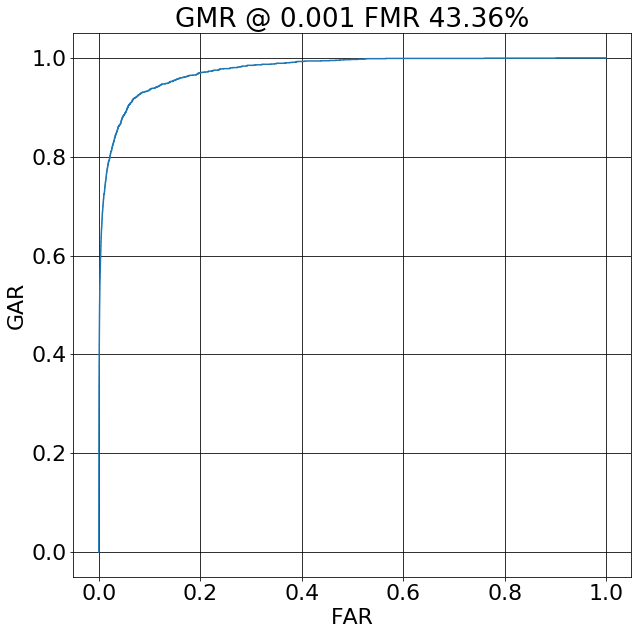

In [15]:

plt.figure(figsize=(10, 10))
far, tar, _ = roc_curve(mt_targets, mt_scores)
plt.plot(far, tar)
plt.xlabel('FAR')
plt.ylabel('GAR')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.title('GMR @ 0.001 FMR ' + '{0:0.2f}'.format(np.min(tar[far>= 0.001] * 100)) + '%')